In [1]:
!git clone https://github.com/CatEatSad/license_plate_detector_usingVGG16_tensorFlow.git

Cloning into 'license_plate_detector_usingVGG16_tensorFlow'...
remote: Enumerating objects: 8660, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 8660 (delta 0), reused 4 (delta 0), pack-reused 8656
Receiving objects: 100% (8660/8660), 938.42 MiB | 24.23 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (10114/10114), done.


In [2]:
%ls
!pip install tensorflow
!pip install keras
!pip install opencv-python
!pip install matplotlib

license_plate_detector_usingVGG16_tensorFlow/  sample_data/


In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob

In [4]:

#gán địa chỉ của file để load ảnh
train_image_file_path = "/content/license_plate_detector_usingVGG16_tensorFlow/data_new_1/images/train"
train_image_labels_path = "/content/license_plate_detector_usingVGG16_tensorFlow/data_new_1/labels/train"
valid_image_file_path = "/content/license_plate_detector_usingVGG16_tensorFlow/data_new_1/images/val"
valid_image_labels_path = "/content/license_plate_detector_usingVGG16_tensorFlow/data_new_1/labels/val"

In [5]:
#Hàm để lấy địa chỉ của ảnh
def load_data_training(directory):
  list_data = glob.glob(directory + "/*")
  return list_data

In [6]:
#địa chỉ của ảnh để train được lưu vào
image_data_train = load_data_training(train_image_file_path)
image_data_train.sort()

#địa chỉ của nhãn dán để train đc lưu vào
labels_data_train = load_data_training(train_image_labels_path)
labels_data_train.sort()

#địa chỉ của ảnh để valid được lưu vào
image_data_valid = load_data_training(valid_image_file_path)
image_data_valid.sort()

#địa chỉ của nhãn dán để valid đc lưu vào
labels_data_valid = load_data_training(valid_image_labels_path)
labels_data_valid.sort()

In [7]:
print(image_data_train[0])
print(labels_data_train[0])
print(image_data_valid[0])
print(labels_data_valid[0])

/content/license_plate_detector_usingVGG16_tensorFlow/data_new_1/images/train/Dieu_0001.png
/content/license_plate_detector_usingVGG16_tensorFlow/data_new_1/labels/train/Dieu_0001.txt
/content/license_plate_detector_usingVGG16_tensorFlow/data_new_1/images/val/Dieu_0003.png
/content/license_plate_detector_usingVGG16_tensorFlow/data_new_1/labels/val/Dieu_0003.txt


In [8]:
#Phần này là phần load ảnh , data ở các vị trí của biển số
data_for_train = [] # list để load ảnh để train
targets_for_train=[] # list để load bounding của ảnh để train
filenames_for_train=[] # load file name của ảnh để train


data_for_valid = [] # list để load ảnh để valid
targets_for_valid = [] # list để load bounding của ảnh để valid
filenames_for_valid = [] # load file name của ảnh để valid

def get_file_name(path):
  return path.split('/')[-1].split('.')[0] # lấy file name

def get_bounding_scale(path):
  f = open(path, "r") # mở file data labels để có thể lấy được
  labels, x1, y1, x2, y2, x3, y3, x4, y4 = f.read().split() # trong 1 file labels bao gồm có 8 phần tử  gồm nhãn và các bounding box của biển số xe
  minX = float(min([x1, x2, x3, x4]))
  minY = float(min([y1, y2, y3, y4])) # bởi vì ta cần 4 phần tử để crop được ảnh của biển số xe nên ta chỉ cần lấy các giá trị maxX , maxY , minX , minY
  maxX = float(max([x1, x2, x3, x4]))
  maxY = float(max([y1, y2, y3, y4]))
  return (minX, minY, maxX, maxY) # lấy kết quả đã thực hiện ở trên




In [9]:
for i in image_data_train: # để phù hợp hơn cho việc xử lý data thì ta cần thay đổi 1 số thứ về ảnh
  image = load_img(i, target_size=(224,224)) # resize lại kích thươcs ảnh gốc thành 224x224
  image = img_to_array(image) # chuyển đổi ảnh sang dạng số  với mỗi
  data_for_train.append(image)
  filenames_for_train.append(get_file_name(i))



In [10]:
for i in image_data_valid:
  image = load_img(i, target_size=(224,224))
  image = img_to_array(image)
  data_for_valid.append(image)
  filenames_for_valid.append(get_file_name(i))

In [11]:
# print(filenames_for_train[0])
# print(filenames_for_valid[0])
print("LOAD " + str(len(filenames_for_train))+" FOR TRAINING")
print("LOAD " + str(len(filenames_for_valid))+" FOR VALIDATION")

LOAD 3105 FOR TRAINING
LOAD 1016 FOR VALIDATION


In [12]:
for j in labels_data_train:
    targets_for_train.append(get_bounding_scale(j))

In [13]:
for j in labels_data_valid:
    targets_for_valid.append(get_bounding_scale(j))

In [14]:
print(len(targets_for_train))
print(len(targets_for_valid))
print(targets_for_train[0])
print(targets_for_valid[0])

3105
1016
(0.3730842911877395, 0.43373601447613225, 0.5330459770114941, 0.59557305604404)
(0.18821839080459773, 0.648148148148148, 0.364463601532567, 0.7720306513409961)


In [15]:
# đổi data sang dạng numpy array
data_for_train = np.array(data_for_train, dtype="float32") / 255.0
targets_for_train = np.array(targets_for_train, dtype="float32")

data_for_valid = np.array(data_for_valid, dtype="float32") / 255.0
targets_for_valid = np.array(targets_for_valid, dtype="float32")

In [16]:
# tách data ra làm 2 phần 90% và 10% , 90 để train còn 10 để test
print(targets_for_train)
print(targets_for_valid)
# split = train_test_split(data,targets,filenames, test_size=0.10, random_state = 42)

[[0.37308428 0.43373603 0.53304595 0.59557307]
 [0.4152299  0.44891444 0.55699235 0.59578544]
 [0.33290926 0.7913486  0.46692112 0.84351146]
 ...
 [0.4126621  0.20302568 0.5980168  0.41253495]
 [0.32036614 0.45525044 0.5156369  0.6952708 ]
 [0.5156369  0.38710907 0.7826087  0.64848715]]
[[0.18821838 0.6481481  0.3644636  0.77203065]
 [0.62404215 0.45657727 0.7801724  0.57279694]
 [0.34817642 0.73282444 0.47201017 0.7773537 ]
 ...
 [0.5041953  0.19387236 0.7048055  0.4216883 ]
 [0.3089245  0.17251462 0.52105266 0.42105263]
 [0.36460716 0.50711924 0.5881007  0.75832695]]


In [ ]:
#  unpack the data split
# (trainImages, testImages) = split[:2]
# (trainTargets, testTargets) = split[2:4]
# (trainFilenames, testFilenames) = split[4:]

In [17]:
print("Length of trainImages:", len(targets_for_train))
print("Length of trainTargets:", len(targets_for_valid))

Length of trainImages: 3105
Length of trainTargets: 1016


In [18]:
#lưu lại tên những file test để có thể sử dụng cho các lần sau
print("[INFO] saving testing filenames...")
f = open("filefortest.txt", "w")
f.write("\n".join(filenames_for_valid))
f.close()

[INFO] saving testing filenames...


In [20]:
model_1 = Sequential()

_input = Input((224,224,3))

model_1.add(_input)

model_1.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model_1.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model_1.add(MaxPooling2D((2, 2)))

model_1.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model_1.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model_1.add(MaxPooling2D((2, 2)))

model_1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_1.add(MaxPooling2D((2, 2)))


model_1.add(Flatten())
model_1.add(Dense(4, activation="sigmoid"))

opt = Adam(1e-4)
model_1.compile(loss = "mse", optimizer= opt, metrics = ["accuracy"])
print(model_1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                 

In [ ]:
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

In [ ]:
vgg.trainable = False

In [ ]:
opt = Adam(1e-4)
model.compile(loss = "mse", optimizer= opt, metrics = ["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 17936548 (68.42 MB)
Trainable params: 3221

In [21]:
K = model_1.fit(
    data_for_train, targets_for_train,
	  validation_data=(data_for_valid, targets_for_valid),
	  batch_size=32,
	  epochs=50,
	  verbose=1
)

Epoch 1/50
98/98 [==============================] - 53s 341ms/step - loss: 0.0134 - accuracy: 0.7568 - val_loss: 0.0099 - val_accuracy: 0.8376
Epoch 2/50
98/98 [==============================] - 27s 274ms/step - loss: 0.0075 - accuracy: 0.8715 - val_loss: 0.0066 - val_accuracy: 0.8789
Epoch 3/50
98/98 [==============================] - 27s 279ms/step - loss: 0.0055 - accuracy: 0.8792 - val_loss: 0.0065 - val_accuracy: 0.8563
Epoch 4/50
98/98 [==============================] - 28s 281ms/step - loss: 0.0049 - accuracy: 0.8921 - val_loss: 0.0054 - val_accuracy: 0.8976
Epoch 5/50
98/98 [==============================] - 28s 285ms/step - loss: 0.0039 - accuracy: 0.8973 - val_loss: 0.0053 - val_accuracy: 0.9065
Epoch 6/50
98/98 [==============================] - 28s 287ms/step - loss: 0.0031 - accuracy: 0.9053 - val_loss: 0.0056 - val_accuracy: 0.8947
Epoch 7/50
98/98 [==============================] - 28s 287ms/step - loss: 0.0025 - accuracy: 0.9085 - val_loss: 0.0048 - val_accuracy: 0.8917

In [ ]:

print("[INFO] training bounding box regressor...")
H = model.fit(
	data_for_train, targets_for_train,
	validation_data=(data_for_valid, targets_for_valid),
	batch_size=32,
	epochs=50,
	verbose=1)


[INFO] training bounding box regressor...


NameError: name 'model' is not defined

In [22]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model_1.save("license_plate_detector.h5", save_format="h5")

[INFO] saving object detector model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


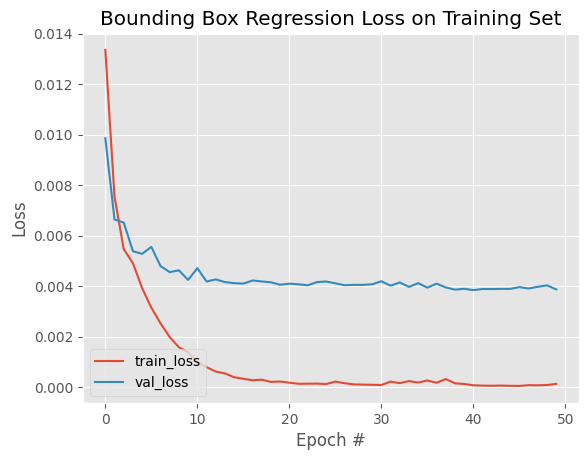

In [24]:
N = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), K.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), K.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("PLOT_PATH")

In [25]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
def inference(imagePath):
    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    # make bounding box predictions on the input image
    preds = model_1.predict(image)[0]
    return preds

In [30]:
def draw_bbox(img, preds):
    image = np.copy(img)
    (startX, startY, endX, endY) = preds
    (h, w) = image.shape[:2]

    # scale the predicted bounding box coordinates based on the image
    # dimensions
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)

    # draw the predicted bounding box on the image
    cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
    return image

1/1 [==============================] - 0s 24ms/step


[0.35802135 0.34464723 0.55459315 0.5631091 ]


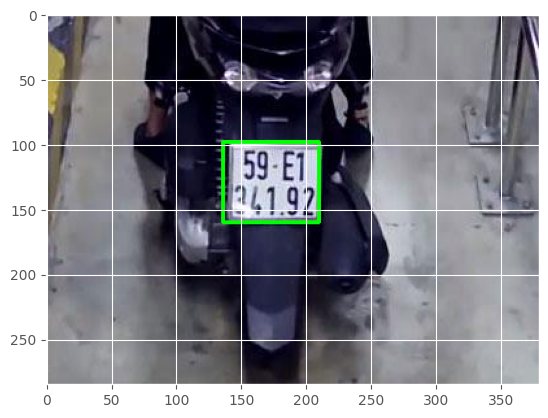

In [34]:
imagePath = '/content/greenpack_0481.png'
image = plt.imread(imagePath)
preds = inference(imagePath)
image_with_bbox = draw_bbox(image, preds)
print(preds)
# show the output image
plt.imshow(image_with_bbox)